Delivery Locations:
Object 1 needs to be delivered to cities: {2, 3, 4, 5, 8, 9}
Object 2 needs to be delivered to cities: {1, 2, 5, 8, 9}
Object 3 needs to be delivered to cities: {0, 1, 2, 5, 8}
Best path meets all delivery requirements: [1, 0, 4, 5, 9, 2, 3, 8]
Cost of best path: 327


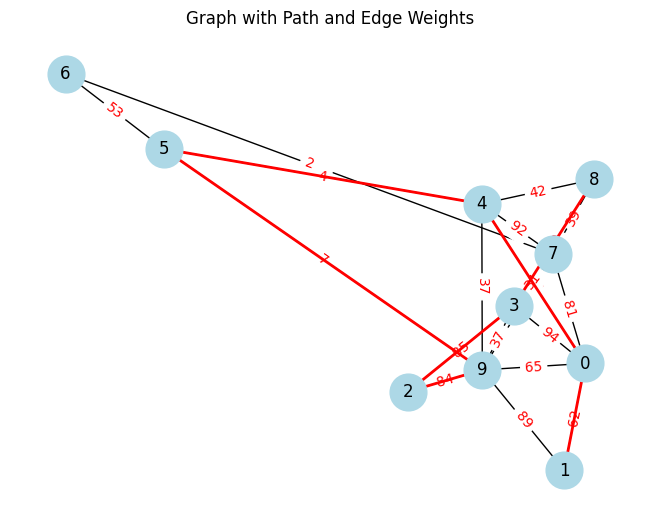

In [21]:
import numpy as np
import random
from matplotlib import pyplot as plt
import networkx as nx

def generate_random_symmetrical_graph(n):
    A = np.random.randint(0, 2, (n, n))
    A = np.triu(A, 1)
    A += A.T
    return tuple(tuple(row) for row in A)

def generate_random_weights(n, max_weight):
    weights = np.random.randint(1, max_weight, (n, n))
    weights = np.triu(weights, 1)
    weights += weights.T
    return tuple(tuple(row) for row in weights)

def generate_random_depot(n, num_objects):
    return tuple(random.sample(range(n), random.randint(1, n)) for _ in range(num_objects))

def generate_random_delivery(n, num_objects):
    return {i: set(random.sample(range(n), random.randint(1, n))) for i in range(num_objects)}

def initialize_pheromones(n, initial_pheromone):
    return np.full((n, n), initial_pheromone)

def update_pheromones(pheromones, paths, decay, contribution, deliveries):
    for path, cost in paths:
        delivery_count = sum(1 for city in path if any(city in deliveries[obj] for obj in deliveries))
        for i, j in zip(path[:-1], path[1:]):
            pheromones[i][j] += (contribution / cost) * (delivery_count / len(deliveries))
    pheromones *= (1 - decay)
    return pheromones


def construct_complete_path(n, graph, pheromones, weights, deliveries):
    path = [random.randint(0, n-1)]
    cost = 0
    visited = set(path)
    required_cities = set().union(*deliveries.values())

    while required_cities.difference(visited):
        current = path[-1]
        choices = [i for i in range(n) if graph[current][i] > 0 and i not in visited]
        if not choices:  # If no choices are left and requirements not met, return an invalid path
            return [], float('inf')  # Return an empty path with infinite cost

        probabilities = [pheromones[current][i] * weights[current][i] * (10 if i in required_cities else 1) for i in choices]
        total = sum(probabilities)
        probabilities = [p / total for p in probabilities]

        next_city = random.choices(choices, weights=probabilities, k=1)[0]
        path.append(next_city)
        visited.add(next_city)
        cost += weights[current][next_city]

    return path, cost




def ant_colony_optimization(n, pheromones, iterations, num_ants, graph, weights, deliveries):
    best_path = None
    best_cost = float('inf')

    for _ in range(iterations):
        paths = [construct_ant_path(n, graph, pheromones, weights, deliveries) for _ in range(num_ants)]
        for path, cost in paths:
            if cost < best_cost and set(path).issuperset(set().union(*deliveries.values())):
                best_path, best_cost = path, cost

        # Update pheromones only for paths meeting the delivery requirements
        valid_paths = [(path, cost) for path, cost in paths if set(path).issuperset(set().union(*deliveries.values()))]
        if valid_paths:
            update_pheromones(pheromones, valid_paths, decay=0.1, contribution=100, deliveries=deliveries)

    return best_path, best_cost



def draw_graph_with_path_and_weights(graph, path, weights):
    G = nx.Graph()
    for i in range(len(graph)):
        for j in range(i, len(graph[i])):
            if graph[i][j] > 0:
                G.add_edge(i, j, weight=weights[i][j])
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)
    plt.title('Graph with Path and Edge Weights')
    plt.show()



if __name__ == '__main__':
    n = 10  # Number of cities
    num_objects = 3  # Number of delivery objects

    graph = generate_random_symmetrical_graph(n)
    weights = generate_random_weights(n, 100)
    deliveries = generate_random_delivery(n, num_objects)
    
    print("Delivery Locations:")
    for obj, locations in deliveries.items():
        print(f"Object {obj + 1} needs to be delivered to cities: {locations}")
    
    pheromones = initialize_pheromones(n, initial_pheromone=1.0)
    best_path, best_cost = ant_colony_optimization(n, pheromones, 100, 20, graph, weights, deliveries)

    if best_path:
        print("Best path meets all delivery requirements:", best_path)
        print("Cost of best path:", best_cost)
        draw_graph_with_path_and_weights(graph, best_path, weights)
    else:
        print("No valid path found that meets all delivery requirements.")

